In [1]:
## Data extracting 

from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import h5py as h5
import os
import sys
import skymapper as skm
import matplotlib.cm as cm
import matplotlib
import copy
from matplotlib.colors import LinearSegmentedColormap

colors = ['#601A4A', '#EE442F','#63ACBE']




from matplotlib import rc
#rc('text', usetex=True)
rc('font', family='serif')
rc('font', size=11)
fontsize='small'


skymapper: survey definitions missing because pymangle is not installed


In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

## Extracting useful columns and saved into .pkl file

In [ ]:
import yaml
import destest
import treecorr


# basic dict props
destest_dict_ = {
    'output_exists' : True,
    'use_mpi'       : False,
    'source'        : 'hdf5',
    'dg'            : 0.01
    }

# Populates a full destest yaml dict for each catalog selection based on the limited catalog input info provided in the common cats.yaml file
def create_destest_yaml( params, name, cal_type, group, table, select_path ):
    """
    Creates the input dictionary structure from a passed dictionary rather than reading froma yaml file.
    """

    destest_dict = destest_dict_.copy()
    destest_dict['load_cache'] = params['load_cache']
    destest_dict['output'] = params['output']
    destest_dict['name'] = name
    destest_dict['filename'] = params['datafile']
    destest_dict['param_file'] = params['param_file']
    destest_dict['cal_type'] = cal_type
    destest_dict['group'] = group
    destest_dict['table'] = table
    destest_dict['select_path'] = select_path
    destest_dict['e'] = ['e_1','e_2']
    destest_dict['Rg'] = ['R11','R22']
    destest_dict['w'] = 'weight'

    return destest_dict

# Build selector (and calibrator) classes from destest for the catalog.
def load_catalog(pipe_params, name, cal_type, group, table, select_path, inherit=None, return_calibrator=None):
    """
    Loads data access and calibration classes from destest for a given yaml setup file.
    """

    # Input yaml file defining catalog
    params = create_destest_yaml(pipe_params, name, cal_type, group, table, select_path)

    # Load destest source class to manage access to file
    source = destest.H5Source(params)

    # Load destest selector class to manage access to data in a structured way
    if inherit is None:
        sel = destest.Selector(params,source)
    else:
        sel = destest.Selector(params,source,inherit=inherit)

    # Load destest calibrator class to manage calibration of the catalog
    if return_calibrator is not None:
        cal = return_calibrator(params,sel)
        return sel, cal
    else:
        return sel

# Read yaml file that defines all the catalog selections used
params = yaml.load(open('/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/cats.yaml'),Loader=yaml.SafeLoader)
params['param_file'] = 'cats.yaml'

# Source catalog
source_selector, source_calibrator = load_catalog(
    params, 'mcal', 'mcal', params['source_group'], params['source_table'], params['source_path'], return_calibrator=destest.MetaCalib)

# Gold catalog
gold_selector = load_catalog(
    params, 'gold', 'mcal', params['gold_group'], params['gold_table'], params['gold_path'], inherit=source_selector)
# BPZ (or DNF) catalog, depending on paths in cats.yaml file (exchange bpz and dnf)
pz_selector = load_catalog(
    params, 'pz', 'mcal', params['pz_group'], params['pz_table'], params['pz_path'], inherit=source_selector)


R1,c,w = source_calibrator.calibrate('e_1') # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
print(R1,c,w)
R2,c,w = source_calibrator.calibrate('e_2')
print(R2,c,w)


# Load ra,dec from gold catalog
ra  = gold_selector.get_col('ra')[0]
dec = gold_selector.get_col('dec')[0]


ra1  = source_selector.get_col('ra')[0]
dec1 = source_selector.get_col('dec')[0]

# Get e1,e2 
g1=source_selector.get_col('e_1')[0]
g2=source_selector.get_col('e_2')[0]
snr =source_selector.get_col('snr')[0]
size_ratio =source_selector.get_col('size_ratio')[0]
w = source_calibrator.calibrate('e_1',weight_only=True) # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
R_array = source_calibrator.calibrate('e_1',return_wRgS=True)


# Save variables to a file
import pickle

with open('shear_data.pkl', 'wb') as f:
    pickle.dump([ra,dec,R1,R2,g1, g2, snr, size_ratio, w, R_array], f)


## Load Variable

In [3]:
with open('shear_data.pkl', 'rb') as f:
    ra,dec,R1,R2,g1, g2, snr, size_ratio, w, R_array = pickle.load(f)

Sample Size (n): 100204026
Sample Mean: 0.00038710125489332107
Sample Variance: 0.04020076627677581
Sample Standard Deviation (std): 0.20050128746912277
Z-Statistic: 19.326357060922042
P-Value: 0.0
The mean is significantly greater than 0.


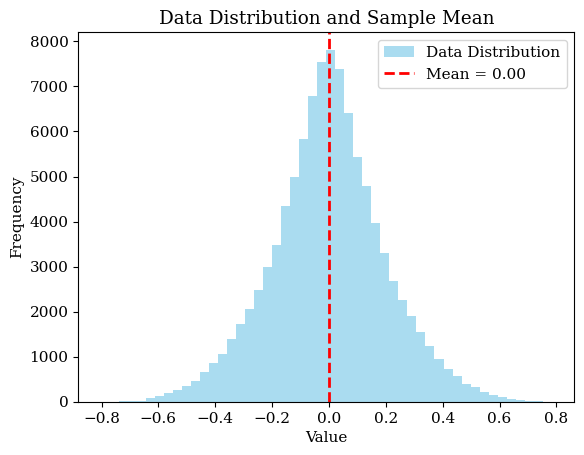

In [31]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Simulate 100 million data points (replace this with your dataset)
np.random.seed(42)  # For reproducibility
data = g1

# Parameters for computation
chunk_size = 10_000_000  # Process 10 million data points at a time
mean_sum = 0
variance_sum = 0
n = 0

# Iterate through chunks
for i in range(0, len(data), chunk_size):
    chunk = data[i:i + chunk_size]
    n_chunk = len(chunk)
    mean_sum += np.sum(chunk)
    variance_sum += np.sum((chunk - np.mean(chunk)) ** 2)  # Welford's method is more robust
    n += n_chunk

# Final mean and variance
mean = mean_sum / n
variance = variance_sum / (n - 1)
std = np.sqrt(variance)

# Perform z-test
z_stat = mean / (std / np.sqrt(n))
p_value = 1 - norm.cdf(z_stat)  # One-tailed test

# Print values
print("Sample Size (n):", n)
print("Sample Mean:", mean)
print("Sample Variance:", variance)
print("Sample Standard Deviation (std):", std)
print("Z-Statistic:", z_stat)
print("P-Value:", p_value)

# Check significance
alpha = 0.05
if p_value < alpha:
    print("The mean is significantly greater than 0.")
else:
    print("The mean is not significantly greater than 0.")

# Plot data distribution (subset for visualization)
subset = data[:100_000]  # Take the first 100,000 data points for plotting
plt.hist(subset, bins=50, alpha=0.7, label="Data Distribution", color="skyblue")
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f"Mean = {mean:.2f}")
plt.title("Data Distribution and Sample Mean")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [27]:
print(np.mean(g1),np.mean(g2))

0.0003871012548933202 6.429987052435421e-05


In [4]:
g1=g1-np.mean(g1)
g2=g2-np.mean(g2)

# g1=(np.mean(g1*w)/np.mean(w))/R1
# g2=(np.mean(g2*w)/np.mean(w))/R2

In [7]:
R1

0.7175082070835618

In [6]:
# def apply_random_rotation(e1_in, e2_in):
#     np.random.seed() # CRITICAL in multiple processes !
#     rot_angle = np.random.rand(len(e1_in))*2*np.pi #no need for 2?
#     cos = np.cos(rot_angle)
#     sin = np.sin(rot_angle)
#     e1_out = + e1_in * cos + e2_in * sin
#     e2_out = - e1_in * sin + e2_in * cos
#     return e1_out, e2_out


# e1_out, e2_out = apply_random_rotation(g1, g2)

In [ ]:
# g1 =(g1 - np.mean(g1*w)/np.mean(w))/R1
# g2 =(g2 - np.mean(g2*w)/np.mean(w))/R2

In [5]:
nside=1024
import healpy as hp

def convert_to_pix_coord(ra, dec, nside):
    """
    Converts right ascension (ra) and declination (dec) to Healpix pixel indices.
    
    Parameters:
    ra : array-like
        Right ascension in degrees.
    dec : array-like
        Declination in degrees.
    nside : int
        The Healpix nside parameter, which defines the resolution of the map.
        
    Returns:
    pix : array-like
        The Healpix pixel indices corresponding to the input coordinates.
    """
    # Convert ra, dec to radians
    theta = np.radians(90 - dec)
    phi = np.radians(ra)
    
    # Use healpy to get the pixel indices
    pix = hp.ang2pix(nside, theta, phi)
    
    return pix


In [8]:
e1_map = np.zeros(hp.nside2npix(nside))
e1_map_w = np.zeros(hp.nside2npix(nside))
e2_map = np.zeros(hp.nside2npix(nside))
e2_map_w = np.zeros(hp.nside2npix(nside))
desy3_map = np.zeros(hp.nside2npix(nside))
desy3_map_w = np.zeros(hp.nside2npix(nside))


pix1 = convert_to_pix_coord(ra,dec, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)

e1_map_w[unique_pix1] += np.bincount(idx_rep1, weights=g1*w)
e2_map_w[unique_pix1] += np.bincount(idx_rep1, weights=g2*w)
e1_map[unique_pix1] += np.bincount(idx_rep1, weights=g1)
e2_map[unique_pix1] += np.bincount(idx_rep1, weights=g2)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
desy3_map_w[unique_pix1] += np.bincount(idx_rep1, weights=w)
mas_desy3 = desy3_map!=0.


e1_map_w[mas_desy3]=(e1_map_w[mas_desy3]/(desy3_map_w[mas_desy3] * 0.676))
e2_map_w[mas_desy3]=(e2_map_w[mas_desy3]/(desy3_map_w[mas_desy3]*0.677))
e1_map[mas_desy3]  =e1_map[mas_desy3]/(desy3_map[mas_desy3])
e2_map[mas_desy3]  =e2_map[mas_desy3]/(desy3_map[mas_desy3])

# mean_e1=np.mean(e1_map)/0.676
# mean_e2=np.mean(e2_map)/0.677

g1_map = e1_map/(0.676)
g2_map = e2_map/(0.677)

# e1_map_w=(-1)*e1_map_w

# mean_g1= np.mean(g1)
# mean_g2= np.mean(g2)
# g1_map -= mean_g1/R1
# g2_map -= mean_g2/R2
# g1_map = g1_map*(-1)


In [54]:
# g_11=(e1_map/R1)-np.mean(e1_map/R1)
# g_21=(e2_map/R2)-np.mean(e2_map/R2)


In [9]:
g1_map=g1_map*(-1)

In [10]:
pixels = np.arange(hp.nside2npix(nside))
pix_mask =pixels[mas_desy3]

In [11]:
"""def g2k_sphere(kappa, gamma1, gamma2, mask, nside=1024, lmax=2048, synfast=False, sm=np.radians(10/60)):

    #Convert shear to convergence on a sphere. In put are all healpix maps.
    

    kappa_mask = kappa * mask
    gamma1_mask = gamma1 * mask
    gamma2_mask = gamma2 * mask

    KQU_masked_maps = [kappa_mask, gamma1_mask, gamma2_mask]
    alms = hp.map2alm(KQU_masked_maps, lmax=lmax,pol=False)  # Spin transform!

    if synfast == False:  # 1/2 missing? **
        ell, emm = hp.Alm.getlm(lmax=lmax)
        almsE = -1*alms[1] *((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
        almsB = -1*alms[2] *((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
        almsE[ell == 0] = 0.0
        almsB[ell == 0] = 0.0
        almsE[ell == 1] = 0.0
        almsB[ell == 1] = 0.0

    else:
        almsE = alms[1]
        almsB = alms[2]

    almssm = [alms[0], almsE, almsB]

    if sm == False:
        kappa_map_alm = hp.alm2map(almssm[0], nside=nside, lmax=lmax, pol=False)
        E_map = hp.alm2map(almssm[1], nside=nside, lmax=lmax, pol=False)
        B_map = hp.alm2map(almssm[2], nside=nside, lmax=lmax, pol=False)

    else:
        kappa_map_alm = hp.alm2map(almssm[0], nside=nside, lmax=lmax, pol=False, sigma=sm)
        E_map = hp.alm2map(almssm[1], nside=nside, lmax=lmax, pol=False, sigma=sm)
        B_map = hp.alm2map(almssm[2], nside=nside, lmax=lmax, pol=False, sigma=sm)

    return kappa_mask, kappa_map_alm, E_map, B_map
"""


def g2k_sphere_2(gamma1, gamma2, mask, nside=1024, lmax=2048,sm=False):
    """
    Convert shear to convergence on a sphere. In put are all healpix maps.
    """

    gamma1_mask = gamma1 * mask
    gamma2_mask = gamma2 * mask

    KQU_masked_maps = [gamma1_mask, gamma1_mask, gamma2_mask]
    alms = hp.map2alm(KQU_masked_maps, lmax=lmax, pol=True)  # Spin transform!


    ell, emm = hp.Alm.getlm(lmax=lmax)
    almsE = alms[1]  * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
    almsB = alms[2] * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
    almsE[ell == 0] = 0.0
    almsB[ell == 0] = 0.0
    almsE[ell == 1] = 0.0
    almsB[ell == 1] = 0.0



    almssm = [alms[0], almsE, almsB]


    kappa_map_alm = hp.alm2map(almssm[0], nside=nside, lmax=lmax, pol=False)
    E_map = hp.alm2map(almssm[1], nside=nside, lmax=lmax, pol=False)
    B_map = hp.alm2map(almssm[2], nside=nside, lmax=lmax, pol=False)

    return E_map, B_map, almsE



In [12]:
E_map, B_map, almsE = g2k_sphere_2(g1_map,g2_map, mas_desy3, nside=nside, lmax=2048)

/var/folders/5_/3zgtm4ks70x91wzj2r9lc_qc0000gn/T/ipykernel_14671/2012802409.py:55: RuntimeWarning: divide by zero encountered in divide
  almsE = alms[1]  * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/var/folders/5_/3zgtm4ks70x91wzj2r9lc_qc0000gn/T/ipykernel_14671/2012802409.py:55: RuntimeWarning: invalid value encountered in multiply
  almsE = alms[1]  * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/var/folders/5_/3zgtm4ks70x91wzj2r9lc_qc0000gn/T/ipykernel_14671/2012802409.py:56: RuntimeWarning: divide by zero encountered in divide
  almsB = alms[2] * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/var/folders/5_/3zgtm4ks70x91wzj2r9lc_qc0000gn/T/ipykernel_14671/2012802409.py:56: RuntimeWarning: invalid value encountered in multiply
  almsB = alms[2] * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5


In [55]:
E_map, B_map, almsE = g2k_sphere_2(e1_map_w,e2_map_w, mas_desy3, nside=nside, lmax=2048)

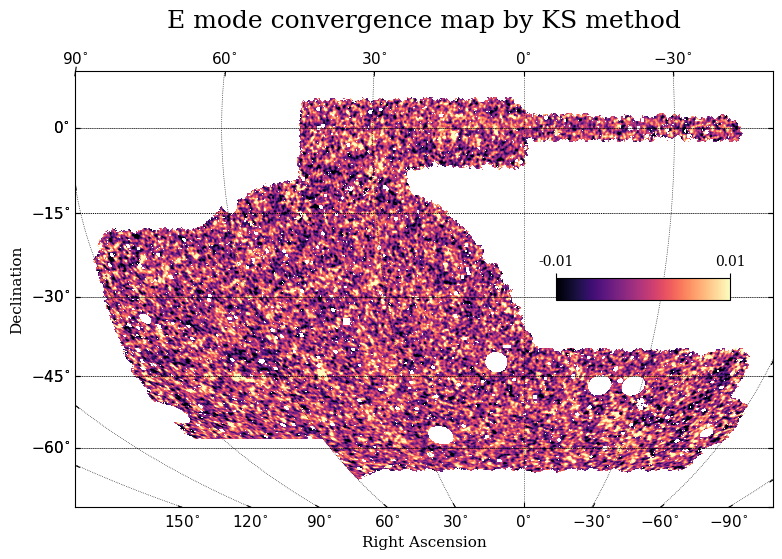

: 

In [ ]:
import healpy as hp
import numpy as np

import matplotlib.pyplot as plt
import skymap

def make_plot_cmap2(mapp, pix_mask, savedir, title, nside=1024, cmap=plt.cm.magma, xsize=5000, smooth=10/60, smoothing=True, vmin=-0.01, vmax=0.01):
    """
    Plot a HEALPix map with optional smoothing and color scale adjustments.
    
    Parameters:
        mapp (array): HEALPix map to plot.
        pix_mask (array): Boolean mask for valid pixels.
        savedir (str): Path to save the plot.
        title (str): Plot title.
        nside (int): HEALPix resolution parameter.
        cmap (str): Matplotlib colormap to use (default: 'inferno').
        xsize (int): Pixel width of the plot.
        smooth (float): Smoothing scale in degrees.
        smoothing (bool): Whether to smooth the map.
        vmin, vmax (float): Min and max values for color scale.
    """

    # Smooth the map manually before plotting
    if smoothing:
        # Apply smoothing (in radians, so convert degrees to radians)
        smoothed_map = hp.smoothing(mapp, sigma=np.radians(smooth), verbose=False)
    else:
        smoothed_map = mapp  # If no smoothing, use the original map

    fig = plt.figure(figsize=(9, 6))
    smap = skymap.DESSkymap()
    ax = plt.gca()

    plt.sca(ax)
    # Pass the smoothed map to draw_hpxmap
    smap.draw_hpxmap(smoothed_map[pix_mask], pix_mask, nside, cmap='magma', vmin=vmin, vmax=vmax, xsize=xsize)

    smap.draw_inset_colorbar(ticks=[vmin, vmax], format='%.2f', fontsize=10, bbox_to_anchor=(-0.05, -0.0, 1, 1))

    plt.title(title, y=1.08, fontsize=18)
    # Save or show the plot
    # plt.savefig(savedir, bbox_inches='tight')
    plt.show()

    # Return the smoothed map array (if needed for further processing)
    return smoothed_map

# Example usage:
# mapp: Your original HEALPix map
# pix_mask: Your pixel mask
# Call make_plot_cmap to smooth the map and plot it
smoothed_map = make_plot_cmap2(E_map, pix_mask, savedir='/path/to/save', title='E mode convergence map by KS method', smooth=10/60, vmin=-0.01, vmax=0.01,smoothing=True)

# Now you have the smoothed map in `smoothed_map` for further analysis or saving


In [57]:
np.max(smoothed_map), np.min(smoothed_map)


(0.02013391703062303, -0.018754251256342856)

In [21]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

def plot_power_spectra_ell(maps, labels, lmax, title, savedir):
    """
    Compute and plot the power spectra of multiple HEALPix maps on the same graph.

    Parameters:
        maps (list of arrays): List of input HEALPix maps.
        labels (list of str): Labels for each map in the plot legend.
        lmax (int): Maximum multipole to consider.
        title (str): Title of the plot.
        savedir (str): Path to save the plot.
    """
    plt.figure(figsize=(10, 7))

    # Loop through the maps to calculate and plot power spectra
    for map_data, label in zip(maps, labels):
        cls = hp.anafast(map_data, lmax=lmax)
        ell = np.arange(len(cls))  # Multipole values
        plt.plot(ell, cls * ell * (ell + 1) / (2 * np.pi), label=label)

    # Customize the plot
    plt.xlabel('$\ell$', fontsize=14)
    plt.ylabel('$\ell(\ell+1)C_\ell / 2\pi$', fontsize=14)
    plt.title(title, fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    # Uncomment this line to save the plot
    # plt.savefig(savedir, bbox_inches='tight')


-3.3915642455374986

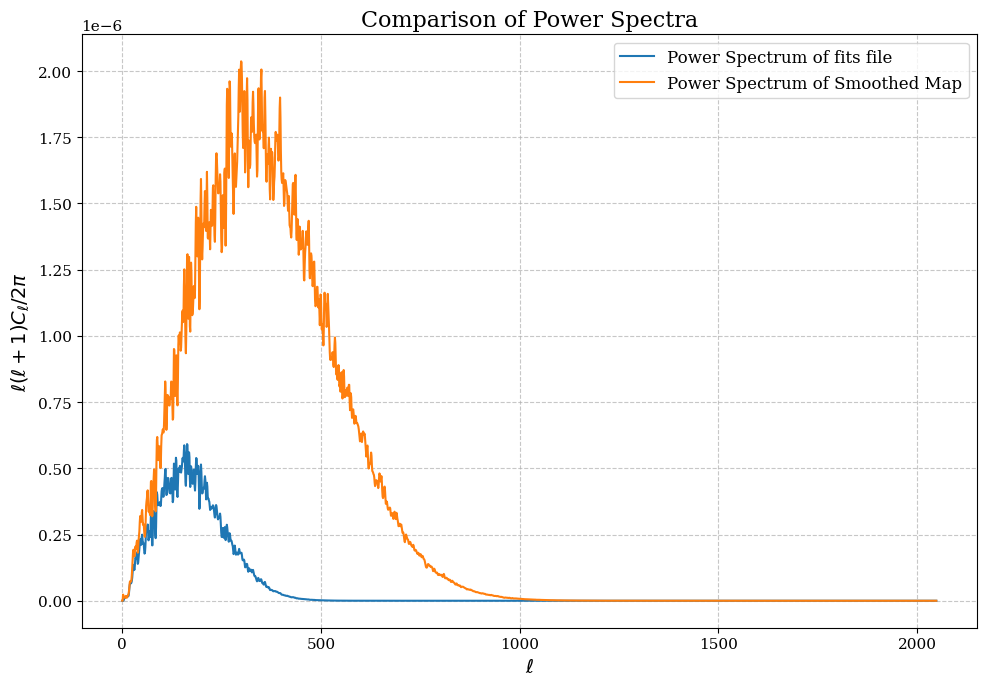

In [37]:
maps = [ hpx_map, smoothed_map]  # Replace with your actual map variables
labels = [
    
    "Power Spectrum of fits file ",
    "Power Spectrum of Smoothed Map",
]
lmax = 2048
plot_power_spectra_ell(maps, labels, lmax, title="Comparison of Power Spectra", savedir="/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/power_spectra_comparison.pdf")


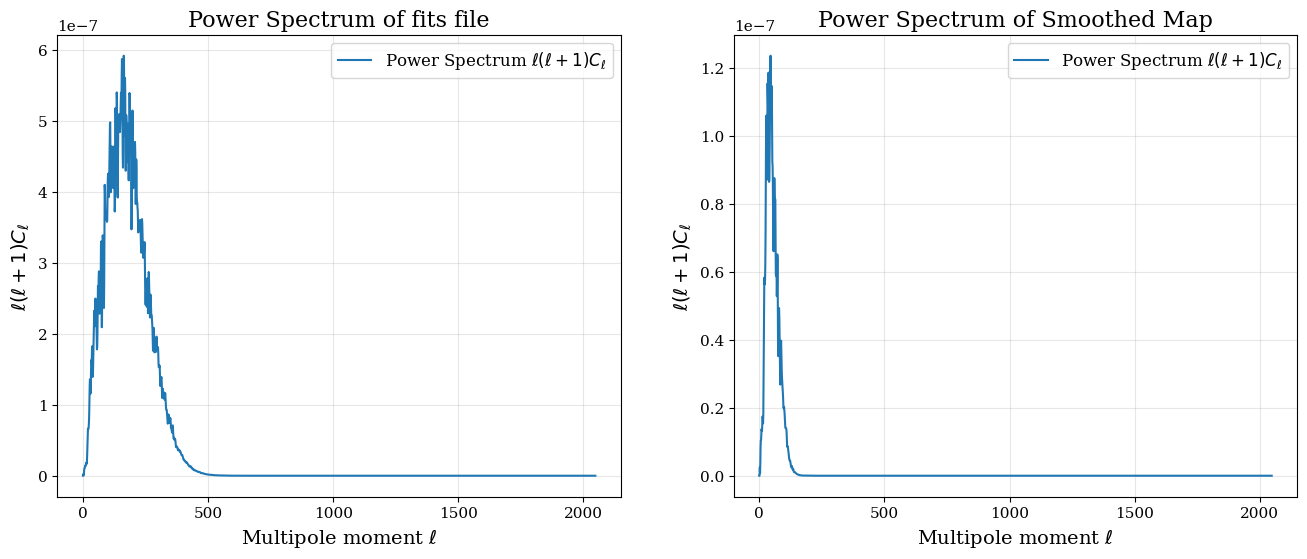

In [33]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

def plot_power_spectrum_ell(ax, map_data, lmax, title):
    """
    Compute and plot the power spectrum of a HEALPix map on a given axis.

    Parameters:
        ax (matplotlib.axes.Axes): Axis to plot on.
        map_data (array): Input HEALPix map.
        lmax (int): Maximum multipole to consider.
        title (str): Title of the plot.
    """
    # Compute the power spectrum
    cls = hp.anafast(map_data, lmax=lmax)
    ell = np.arange(len(cls))  # Multipole values
    
    # Multiply the power spectrum by the factor l(l+1)
    factor = ell * (ell + 1)/(2 * np.pi)
    cls *= factor
    
    # Plot the power spectrum
    ax.plot(ell, cls, label=r'Power Spectrum $\ell(\ell+1)C_\ell$')
    ax.set_xlabel(r'Multipole moment $\ell$', fontsize=14)
    ax.set_ylabel(r'$\ell(\ell+1)C_\ell$', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=12)

# Create a new function to handle subplots
def plot_power_spectra_subplots(hpx_map, smoothed_map, lmax, savedir1, savedir2):
    """
    Plot power spectra of two HEALPix maps in subplots.

    Parameters:
        hpx_map (array): First HEALPix map.
        smoothed_map (array): Second HEALPix map.
        lmax (int): Maximum multipole to consider.
        savedir1 (str): Path to save the first plot.
        savedir2 (str): Path to save the second plot.
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the power spectrum of the first map
    plot_power_spectrum_ell(axs[0], hpx_map, lmax, title='Power Spectrum of fits file')

    # Plot the power spectrum of the second map
    plot_power_spectrum_ell(axs[1], smoothed_map, lmax, title='Power Spectrum of Smoothed Map')

    # Save the plots
    # plt.savefig(savedir1, bbox_inches='tight')
    # plt.savefig(savedir2, bbox_inches='tight')
    plt.show()

# Example usage
smoothed_map = hp.smoothing(hpx_map, sigma=np.deg2rad(1.0))  # Example smoothing
lmax = 2048

plot_power_spectra_subplots(hpx_map, smoothed_map, lmax, 
                            savedir1='/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/power_spectrum_fits_file.pdf', 
                            savedir2='/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/power_spectrum_smoothed_map.pdf')

In [18]:

fits_file = "/Users/supriyosaha/Desktop/DP1/fits_files/KS_full.fits"  # Replace with your FITS file path
hpx_map = hp.read_map(fits_file, verbose=False)  # Read the HEALPix map

In [60]:
hpx_map[5],smoothed_map[5]

(1.4979208911663238e-06, 3.857636910556512e-06)

In [ ]:
np.min(hpx_smoothed), np.max(hpx_smoothed)

(-0.010843482839144736, 0.0143995260720576)

In [33]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

def plot_power_spectra_log(maps, labels, lmax, title, savedir):
    """
    Compute and plot the power spectra of multiple HEALPix maps on the same graph.

    Parameters:
        maps (list of arrays): List of input HEALPix maps.
        labels (list of str): Labels for each map in the plot legend.
        lmax (int): Maximum multipole to consider.
        title (str): Title of the plot.
        savedir (str): Path to save the plot.
    """
    plt.figure(figsize=(10, 7))

    # Loop through the maps to calculate and plot power spectra
    for map_data, label in zip(maps, labels):
        cls = hp.anafast(map_data, lmax=lmax)
        ell = np.arange(len(cls))  # Multipole values
        plt.plot(ell, np.log(cls * ell * (ell + 1) / (2 * np.pi)), label=label)

    # Customize the plot
    plt.xlabel('$\ell$', fontsize=14)
    plt.ylabel('$log(\ell(\ell+1)C_\ell / 2\pi)$', fontsize=14)
    plt.title(title, fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    # Uncomment this line to save the plot
    # plt.savefig(savedir, bbox_inches='tight')


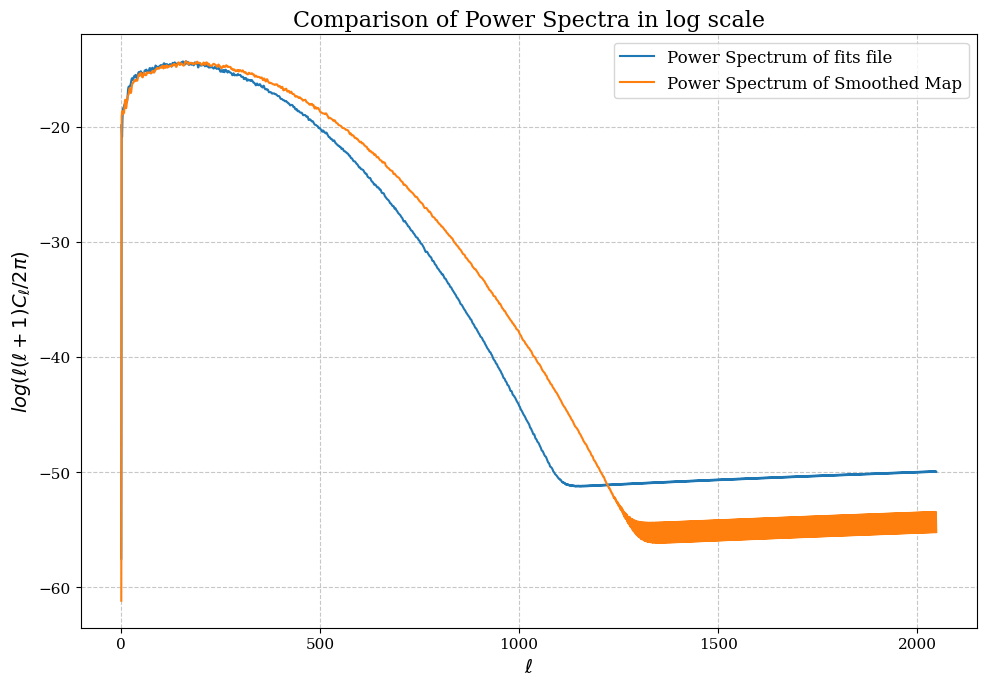

In [34]:
maps = [ hpx_map, smoothed_map]  # Replace with your actual map variables
labels = [
    
    "Power Spectrum of fits file ",
    "Power Spectrum of Smoothed Map",
]
lmax = 2048
plot_power_spectra_log(maps, labels, lmax, title="Comparison of Power Spectra in log scale", savedir="/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/power_spectra_comparison.pdf")


In [217]:
import healpy as hp
help(hp.map2alm)

Help on function map2alm in module healpy.sphtfunc:

map2alm(maps, lmax=None, mmax=None, iter=3, pol=True, use_weights=False, datapath=None, gal_cut=0, use_pixel_weights=False, verbose=True)
    Computes the alm of a Healpix map. The input maps must all be
    in ring ordering.
    
    For recommendations about how to set `lmax`, `iter`, and weights, see the
    `Anafast documentation <https://healpix.sourceforge.io/html/fac_anafast.htm>`_
    
    Pixel values are weighted before applying the transform:
    
    * when you don't specify any weights, the uniform weight value 4*pi/n_pix is used
    * with ring weights enabled (use_weights=True), pixels in every ring
      are weighted with a uniform value similar to the one above, ring weights are
      included in healpy
    * with pixel weights (use_pixel_weights=True), every pixel gets an individual weight
    
    Pixel weights provide the most accurate transform, so you should always use them if
    possible. However they are not 

In [218]:
import skymap
help(skymap.DESSkymap.draw_hpxmap)


Help on function draw_hpxmap in module skymap.core:

draw_hpxmap(self, hpxmap, pixel=None, nside=None, xsize=800, lonra=None, latra=None, badval=-1.6375e+30, smooth=None, **kwargs)
    Use pcolor/pcolormesh to draw healpix map.
    
    Parameters:
    -----------
    hpxmap: input healpix map
    pixel:  explicit pixel indices (required for partial maps)
    nside:  explicit nside of the map (required for partial maps)
    xsize:  resolution of the output image
    lonra:  longitude range [-180,180] (deg)
    latra:  latitude range [-90,90] (deg)
    badval: set of values considered "bad"
    smooth: gaussian smoothing kernel (deg)
    
    Returns:
    --------
    im,lon,lat,values : mpl image with pixel longitude, latitude (deg), and values



    def draw_hpxmap(self, hpxmap, pixel=None, nside=None, xsize=800,
                    lonra=None, latra=None, badval=hp.UNSEEN, smooth=None, **kwargs):
        """
        Use pcolor/pcolormesh to draw healpix map.

        Parameters:
        -----------
        hpxmap: input healpix map
        pixel:  explicit pixel indices (required for partial maps)
        nside:  explicit nside of the map (required for partial maps)
        xsize:  resolution of the output image
        lonra:  longitude range [-180,180] (deg)
        latra:  latitude range [-90,90] (deg)
        badval: set of values considered "bad"
        smooth: gaussian smoothing kernel (deg)

        Returns:
        --------
        im,lon,lat,values : mpl image with pixel longitude, latitude (deg), and values
        """
        healpix.check_hpxmap(hpxmap,pixel,nside)
        hpxmap = healpix.masked_array(hpxmap,badval)

        if smooth:
            # To smooth we need the full map
            hpxmap = healpix.create_map(hpxmap,pixel,nside,badval)
            pixel,nside = None,None
            hpxmap = healpix.masked_array(hpxmap,badval)
            hpxmap = self.smooth(hpxmap,sigma=smooth)

        #if pixel is None:
        #    nside = hp.get_nside(hpxmap.data)
        #    pixel = np.arange(len(hpxmap),dtype=int)
        #elif nside is None:
        #    msg = "'nside' must be specified for explicit maps"
        #    raise Exception(msg)

        vmin,vmax = np.percentile(hpxmap.compressed(),[2.5,97.5])

        defaults = dict(latlon=True, rasterized=True, vmin=vmin, vmax=vmax)
        setdefaults(kwargs,defaults)

        lon,lat,values = healpix.hpx2xy(hpxmap,pixel=pixel,nside=nside,
                                        xsize=xsize,
                                        lonra=lonra,latra=latra)

        # pcolormesh doesn't work in Ortho...
        if self.projection == 'ortho':
            im = self.pcolor(lon,lat,values,**kwargs)
        else:
            # Why were we plotting the values.data?
            #im = self.pcolormesh(lon,lat,values.data,**kwargs)

            # pcolormesh recommends that values be larger than x,y
            # but basemap has problems with this (sometimes?)
            # https://github.com/matplotlib/basemap/issues/182
            try: 
                im = self.pcolormesh(lon,lat,values,**kwargs)
            except IndexError:
                im = self.pcolormesh(lon[:-1,:-1],lat[:-1,:-1],values,**kwargs)

        return im,lon,lat,values



In [219]:
print(inspect.getsource(smap.smooth))


    def smooth(self,hpxmap,badval=hp.UNSEEN,sigma=None):
        """ Smooth a healpix map """
        healpix.check_hpxmap(hpxmap,None,None)
        hpxmap = healpix.masked_array(hpxmap,badval)
        hpxmap.fill_value = np.ma.median(hpxmap)
        smooth = hp.smoothing(hpxmap,sigma=np.radians(sigma),verbose=False)
        return np.ma.array(smooth,mask=hpxmap.mask)



In [27]:
x=[1,2,3,4]
y=x
y[1]=9
print(x)

[1, 9, 3, 4]
